# A Multiagent transportation system

Auteur : Philippe Mathieu, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Corwin Fèvre (CRISTAL/SMAC , CRISTAL/OSM)

Creation : 15/01/2020


## Principe général


Cette feuille fait suite à [mas_basics_fr.ipynb](mas_basics_fr.ipynb) qui donnait les bases de la construction d'un système multi-agents sur un reseau social.
Nous vous montrons ici, comment réaliser une petite simulation d'un système de co-voiturage à l'aide des agents.

## La simulation du trafic

In [392]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from timeit import default_timer as timer
from math import ceil, floor
import copy
import pandas as pd

## Le réseau routier
Dans une simulation de trafic, on détermine tout d'abord un réseau routier. Il existe plusieurs échelles de réseau routier : une simple route à une ou plusieurs voies, une ville, une région ou encore un pays. Dans ce document nous nous intéresserons à l'échelle d'une ville, plus précisément à l'ile de Manahttan dont les rues ont la spécificité de dessiner une grille géante. Cette structure a le bénéfice d'être régulière et donc d'éviter des cas particuliers aléatoires. Nous prendrons le soin de supprimer quelques arrêtes afin que les recherches de plus court chemin aient un intérêt.

In [395]:
#fonction permettant de générer un graphe en grille aléatoire avec perturbation d'arête 
#n indique le nombre de noeuds au carré
#la variable coef suppr détermine le coefficient de suppression des arêtes
#la variable show indique si il faut afficher le graphe ou non
def generate_2D_graph(n, coef_suppr=False, show=False):
    graph = nx.grid_2d_graph(n, n)  # n x n grid

    if coef_suppr != False:
        nb_suppr = int(len(list(graph.nodes))*coef_suppr)

        random_edge(graph, nb_suppr, delete=True)
    
    pos = nx.spring_layout(graph, iterations=100)

    
    graph.remove_nodes_from(list(nx.isolates(graph)))
    graph = graph.to_directed()
    
    if show:
        nx.draw(graph, pos, node_color='b', node_size=20, with_labels=False)
        plt.title("Road network")
        plt.show()
        
    return graph

#ajoute ou supprime un nombre d'arêtes dans un graphe
def random_edge(graph, nb_edges, delete=True):
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    # random edge choice
    if delete:
        # delete chosen edge
        chosen_edges = random.sample(edges, nb_edges)
        for edge in chosen_edges :
            graph.remove_edge(edge[0], edge[1])
    # add new edge
    else:
        chosen_nonedges = random.sample(nonedges, nb_edges)
        for non_edge in chosen_nonedges:
            graph.add_edge(non_edge[0], non_edge[1])

    return graph

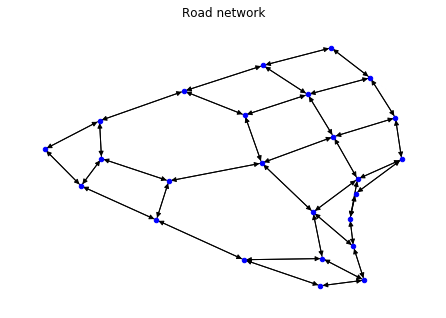

In [430]:
graph = generate_2D_graph(5, coef_suppr=0.1, show=True)

## Les Agents

Les agents de notre système disposeront toujours d'un identifiant unique et d'un état : vivant ou mort. Cet état indique leur activité dans le système, si ils sont vivants, ils sont actifs et ils réagissent avec leur environnement, sinon ils sont sortis du système.

In [431]:
class Agent:
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.is_alive = True
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass

### L'agent conducteur
Un agent conducteur dispose d'un noeud actuel, d'un noeud de destination et d'un trajet : une succession de positions contiguës qu'il va parcourir.
À chaque pas de simulation, il supprime le premier élément de son trajet et met à jour son noeud actuel, simulant ainsi une avancée dans son voyage.
Il avance obligatoirement à chaque pas de simulation et toujours au plus court chemin entre son point de départ et d'arrivé.

In [432]:
class DriverAgent(Agent):
    def __init__(self, unique_id, trip):
        super().__init__(unique_id)
        self.v_arr = trip[-1]
        self.v_r = trip[0]
        self.trip = trip
        
    def to_string(self):
        print("I am driver",self.unique_id,"- trip:",self.trip)
        
    def update(self) :
        pass
            
    def decide(self) :
        if len(self.trip)>1:
            old = self.trip.pop(0)
            self.v_r = self.trip[0]
            print("Driver",self.unique_id,"moving from",old,"to",self.v_r)
        else :
            self.is_alive = False
            
            print("Driver",self.unique_id,"arrived")         

On va creer et simuler l'avancée d'un conducteur dans le graphe défini précédemment.

In [433]:
#on récupère 2 noeuds aléatoires dans le graphe
n1, n2 = random.sample(list(graph.nodes),2) 
#on récupère le chemin le plus court entre ces deux noeuds
trip = nx.shortest_path(graph, n1, n2)
#puis on créer un agent conducteur et on associe ce chemin à son itinéraire
d = DriverAgent(0, trip)

In [434]:
d.to_string()
#tant que le conducteur n'est pas arrivé à destination
while d.is_alive == True:
    #il fait une action
    d.decide()

I am driver 0 - trip: [(3, 4), (2, 4), (1, 4), (0, 4), (0, 3), (0, 2), (0, 1)]
Driver 0 moving from (3, 4) to (2, 4)
Driver 0 moving from (2, 4) to (1, 4)
Driver 0 moving from (1, 4) to (0, 4)
Driver 0 moving from (0, 4) to (0, 3)
Driver 0 moving from (0, 3) to (0, 2)
Driver 0 moving from (0, 2) to (0, 1)
Driver 0 arrived


### L'agent passager
Un agent passager dispose d'un noeud de départ, d'un noeud d'arrivée et d'un noeud actuel.
Son but est de rejoindre son noeud d'arrivée en empruntant le véhicule de conducteurs passant par son noeud, il a le comportement d'un auto-stoppeur. À chaque pas de simulation, il recherchera sur son noeud si il y a un ou plusieurs agents conducteurs lui permettant d'avancer dans son objectif, dans le cas contraire il restera sur son noeud.

In [435]:
class RiderAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr, strategy='transition'):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        
    def to_string(self):
        print("I am rider",self.unique_id,"- dep:",self.v_dep,", arr:",self.v_arr)
                 
            
    def update(self):
        cur_node = self.v_r
        global agentList
        #si il existe au moins un véhicule sur ce noeud actuellement
        #alors on s'interroge sur une eventuelle prise en charge
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "DriverAgent" and agent.v_r == self.v_r and len(agent.trip)>1)]
        if len(caragent) > 0:
            best_driver = None
            for ad in caragent:
                next_node = ad.trip[1]
                #on effectue la différence de la distance actuelle entre le passager et son noeud d'arrivé
                #avec la distance potentielle en empruntant le véhicule.
                #Si la valeur est positive, alors le véhicule fait avancer le passager dans son trajet.
                contrib = nx.shortest_path_length(graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(graph, source=next_node, target=self.v_arr)
                if contrib > 0:
                    best_driver = ad
                    break
            
            if best_driver != None :
                #le passager le prends et mets à jour sa position
                new_node = best_driver.trip[1]
                print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver.unique_id)
                #si c'est son arrivée, l'agent meurt
                if new_node == self.v_arr:
                    print("Rider n°",self.unique_id,"arrived")
                    self.is_alive = False
                    return
            #sinon l'agent ne bouge pas    
            else : 
        
                print("Agent rider",self.unique_id,"doesn't move")
                new_node = cur_node
            
        #sinon l'agent ne bouge pas    
        else:
            
            print("Agent rider",self.unique_id,"doesn't move")
            new_node = cur_node
        
        self.v_r = new_node
        
    def decide(self):
        pass

On peut alors créer des agents conducteurs et des agents passagers :

In [436]:
agentList = []

#conducteurs
for i in range(10) :
    #on récupère 2 noeuds aléatoires dans le graphe
    n1, n2 = random.sample(list(graph.nodes),2) 
    #on récupère le chemin le plus court entre ces deux noeuds
    trip = nx.shortest_path(graph, n1, n2)
    #puis on créer un agent conducteur et on associe ce chemin à son itinéraire
    d = DriverAgent(i, trip)
    agentList.append(d)
  
#passagers
for i in range(10,15):
    #on récupère 2 noeuds aléatoires dans le graphe
    n1, n2 = random.sample(list(graph.nodes),2) 
    #puis on créer un agent passager avec pour départ et destination ces noeuds
    r = RiderAgent(i, n1, n2)
    agentList.append(r)


Et les faire évoluer dans notre environnement, ici on continu l'éxécution du process tant que les conducteurs ne sont pas tous arrivés à destination.

In [437]:
for a in agentList :
    a.to_string()
while len([agent for agent in agentList if (agent.__class__.__name__ == "DriverAgent")]) > 0:
    for a in agentList:
        a.update()
        a.decide()
        
    for a in agentList:
        if a.is_alive == False:
            agentList.remove(a)
        

I am driver 0 - trip: [(3, 2), (2, 2), (2, 1), (3, 1)]
I am driver 1 - trip: [(4, 4), (3, 4), (2, 4), (1, 4), (0, 4), (0, 3)]
I am driver 2 - trip: [(0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0)]
I am driver 3 - trip: [(4, 1), (3, 1), (2, 1), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]
I am driver 4 - trip: [(3, 4), (3, 3), (3, 2)]
I am driver 5 - trip: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
I am driver 6 - trip: [(4, 1), (4, 0)]
I am driver 7 - trip: [(2, 3), (2, 2), (2, 1), (3, 1)]
I am driver 8 - trip: [(2, 3), (2, 2), (2, 1)]
I am driver 9 - trip: [(0, 1), (1, 1), (1, 2), (2, 2), (3, 2), (4, 2)]
I am rider 10 - dep: (3, 1) , arr: (2, 3)
I am rider 11 - dep: (1, 2) , arr: (3, 0)
I am rider 12 - dep: (4, 4) , arr: (2, 2)
I am rider 13 - dep: (2, 1) , arr: (3, 3)
I am rider 14 - dep: (4, 3) , arr: (4, 4)
Driver 0 moving from (3, 2) to (2, 2)
Driver 1 moving from (4, 4) to (3, 4)
Driver 2 moving from (0, 2) to (0, 1)
Driver 3 moving from (4, 1) to (3, 1)


Bien évidemment, un système multi-agent utilise des dizaines voire des milliers d'agents. Il est alors necessaire de créer une classe permettant de les manager. En général la méthode qui lance la simulation se nomme run et prend en paramètre le nombre de prises de paroles. De plus, on remarquera que chaque agent dispose d'un état : vivant ou non. Dans notre système, un agent est vivant tant que son objectif n'est pas rempli.
Ainsi les agents passagers et conducteurs seront vivants tant qu'ils ne sont pas arrivés à destination, le SMA s'occupera de mettre à jour la liste des agents du système en fonction de leur êtat. Il stockera aussi les données interessantes à collecter des agents morts (temps de trajet etc...).
On ajoutera aussi un verbose pour éviter les affichages inutiles.

In [438]:
import random
class SMA:
    def __init__(self, verbose=False):
        self.tick=0
        self.resetTicks()
        self.agentList = []
        self.graph = None
        self.verbose = verbose
        #déclaration variable de la recup des données
        self.data = {}

    def resetTicks(self):
        tick=0
          
    def setRoadGraph(self,graph):
        self.graph = graph
        
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        #initialisation
        self.data["mean_travel_time_r"] = []
        
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentList :
            ag.update()
            ag.decide()
            
        for ag in self.agentList:
            if ag.is_alive == False:
                #si c'est un agent passager
                if ag.__class__.__name__ == "RiderAgent":
                    #on recupère son temps total d'attente
                    self.data["mean_travel_time_r"].append(ag.travel_time)
                self.agentList.remove(ag)
                
        if self.verbose == True:      
            print("tick "+str(self.tick)+" ended")

On mettra aussi à jour nos agents afin qu'ils se basent sur le graphe et la liste des agents du sma.

In [439]:
class RiderAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr, strategy='transition'):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        self.travel_time = 0
        
    def to_string(self):
        print("I am rider",self.unique_id,"- dep:",self.v_dep,", arr:",self.v_arr)
                 
            
    def update(self):
        cur_node = self.v_r
        #on retire ici cette ligne
        #global agentList
       
        #ici on modifie en sma.agentList
        caragent = [agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent" and agent.v_r == self.v_r and len(agent.trip)>1)]
        if len(caragent) > 0:
            best_driver = None
            for ad in caragent:
                next_node = ad.trip[1]
                #ici en sma.graph
                contrib = nx.shortest_path_length(sma.graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=next_node, target=self.v_arr)
                if contrib > 0:
                    best_driver = ad
                    break
            
            if best_driver != None :
                new_node = best_driver.trip[1]
                if sma.verbose == True:
                    print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver.unique_id)
                if new_node == self.v_arr:
                    if sma.verbose == True:
                        print("Rider n°",self.unique_id,"arrived")
                    self.is_alive = False
                    return    
            else : 
                if sma.verbose == True:
                    print("Agent rider",self.unique_id,"doesn't move")
                new_node = cur_node
               
        else:  
            if sma.verbose == True:
                print("Agent rider",self.unique_id,"doesn't move")
            new_node = cur_node
        
        self.v_r = new_node
        self.travel_time += 1
        
    def decide(self):
        pass

In [440]:
class DriverAgent(Agent):
    def __init__(self, unique_id, trip):
        super().__init__(unique_id)
        self.v_arr = trip[-1]
        self.v_r = trip[0]
        self.trip = trip
        
    def to_string(self):
        print("I am driver",self.unique_id,"- trip:",self.trip)
        
    def update(self) :
        pass
            
    def decide(self) :
        if len(self.trip)>1:
            old = self.trip.pop(0)
            self.v_r = self.trip[0]
            if sma.verbose == True:
                print("Driver",self.unique_id,"moving from",old,"to",self.v_r)
        else :
            self.is_alive = False
            if sma.verbose == True:
                print("Driver",self.unique_id,"arrived")  

On peut ainsi créer notre SMA, lui associer des passagers et des conducteurs et effectuer 6 runs par exemple.

In [441]:
sma = SMA(verbose=True)
sma.graph = graph

#conducteurs
for i in range(5) :
    #on récupère 2 noeuds aléatoires dans le graphe
    n1, n2 = random.sample(list(sma.graph.nodes),2) 
    #on récupère le chemin le plus court entre ces deux noeuds
    trip = nx.shortest_path(sma.graph, n1, n2)
    #puis on créer un agent conducteur et on associe ce chemin à son itinéraire
    d = DriverAgent(i, trip)
    sma.addAgent(d)
  
#passagers
for i in range(5,10):
    #on récupère 2 noeuds aléatoires dans le graphe
    n1, n2 = random.sample(list(sma.graph.nodes),2) 
    #puis on créer un agent passager avec pour départ et destination ces noeuds
    r = RiderAgent(i, n1, n2)
    sma.addAgent(r)

sma.run(6)

Driver 0 moving from (4, 2) to (3, 2)
Driver 1 moving from (0, 3) to (1, 3)
Driver 2 moving from (0, 4) to (0, 3)
Driver 3 moving from (3, 0) to (4, 0)
Driver 4 moving from (1, 2) to (0, 2)
Agent rider 5 doesn't move
Agent rider 6 move from (3, 2) to (3, 3) using car 0
Agent rider 7 doesn't move
Agent rider 8 doesn't move
Agent rider 9 doesn't move
tick 1 ended
Driver 0 moving from (3, 2) to (3, 3)
Driver 1 moving from (1, 3) to (2, 3)
Driver 2 moving from (0, 3) to (1, 3)
Driver 3 moving from (4, 0) to (4, 1)
Driver 4 arrived
Agent rider 5 doesn't move
Agent rider 6 doesn't move
Agent rider 7 doesn't move
Agent rider 8 doesn't move
Agent rider 9 doesn't move
tick 2 ended
Driver 0 arrived
Driver 1 arrived
Driver 2 arrived
Driver 3 moving from (4, 1) to (4, 2)
Agent rider 5 doesn't move
Agent rider 6 doesn't move
Agent rider 7 doesn't move
Agent rider 8 doesn't move
Agent rider 9 doesn't move
tick 3 ended
Driver 1 arrived
Driver 3 moving from (4, 2) to (4, 3)
Agent rider 5 doesn't move


### L'agent générateur de trafic
Nous avons donc défini les classes d'agents présentes dans notre simulation de trafic, nous avons défini le fonctionnement du système multi-agents, mais nous avons testé ce système uniquement avec un nombre défini d'utilisateurs. Hors, en situation réelle, il existe une source continu de conducteurs et de passagers qui entre et sorte du système. Pour simuler cette source continue d'utilisateurs du système nous avons créé un agent générateur de trafic.

Il faut savoir qu'un agent n'est pas forcément quelque chose qui "bouge". Il peut aussi être responsable de différente taches du système comme la récolte et la transmission de données, l'optimisation ou dans le cas de présent de la génération d'autres agents.


Cet agent aura pour role la gestion du nombre maximal d'agents conducteurs et passagers dans le système et de leur identification.

In [442]:
class GeneratorAgent(Agent):
    def __init__(self, current_id, max_drivers, max_riders, seed=None):
        super().__init__(current_id)
        self.n_id = current_id+1
        self.seed = seed
        if self.seed!=None:
            random.seed(seed)
        
        self.max_drivers = max_drivers
        self.max_riders = max_riders
        
    #gestion des id unique    
    def next_id(self):
        self.n_id += 1
        return self.n_id

    

    #genere les agents conducteurs
    def driverAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2) 
        trip = nx.shortest_path(sma.graph, n1, n2)
        d = DriverAgent(self.next_id(), trip)
        sma.addAgent(d)
        

    #genere les agents passagers
    def riderAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2) 
        r = RiderAgent(self.next_id(), n1, n2)
        sma.addAgent(r)
        
    def update(self):
        
        #on récupère le nombre d'agents dans le système
        nb_drivers = len([agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent")])
        nb_riders = len([agent for agent in sma.agentList if (agent.__class__.__name__ == "RiderAgent")])
        
        #puis on complète par rapport au nombre maximal fixé
        driver_difference = self.max_drivers - nb_drivers
        rider_difference = self.max_riders - nb_riders
        
        for i in range(driver_difference):
            self.driverAgentGenerator()
        if sma.verbose == True:
            print(driver_difference,"drivers generated.")
            
        for i in range(rider_difference):
            self.riderAgentGenerator()
        if sma.verbose == True:
            print(rider_difference,"riders generated.") 
        
    def decide(self):
        pass
        

On va alors définir les paramètres de notre simulation :

In [443]:
SIZE_MAP = 5 #graphe en grille donc NOMBRE DE NOEUDS = SIZE_MAP * SIZE_MAP
MAX_NB_DRIVERS = 20
MAX_NB_RIDERS = 10
NB_RUN = 200

Puis lancer notre simulation :

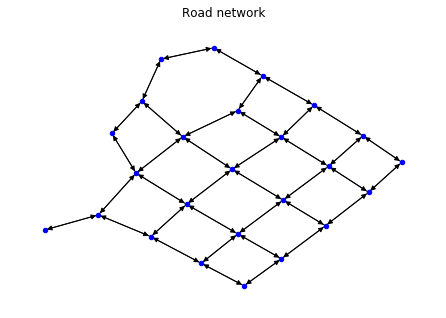

In [444]:
sma = SMA()
sma.setRoadGraph(generate_2D_graph(SIZE_MAP, coef_suppr=0.1, show=True))
sma.addAgent(GeneratorAgent(0,MAX_NB_DRIVERS,MAX_NB_RIDERS))
sma.run(NB_RUN)

In [445]:
print("Temps moyen de trajet des passagers arrivés a destination:", np.mean(sma.data["mean_travel_time_r"]),"pas de simulation")

Temps moyen de trajet des passagers arrivés a destination: 12.602836879432624 pas de simulation


## Expérimentations et Résultats
Nous avons défini le coeur de notre simulateur de trafic, il s'agit maintenant de mettre en place des indicateurs afin de déterminer si une configuration est meilleure qu'une autre et pourquoi.

### Le temps de trajet :
On peut émettre une hypothèse simple : plus il y a de véhicules disponibles, plus il y a de possibilités d'acheminement pour les passagers et donc ces derniers arrivent plus vite à destination. En conséquence, le temps moyen de trajet des agents passagers devrait décroître en fonction du nombre d'agents conducteurs.

Pour démontrer simplement ce cas de figure, on va effectuer plusieurs simulations avec le même réseau routier, le même nombre de passagers et en faisant varier le nombre de conducteurs.

In [446]:
SIZE_MAP = 5 #graphe en grille donc NOMBRE DE NOEUDS = SIZE_MAP * SIZE_MAP
MAX_NB_DRIVERS = np.arange(5,50,3)
MAX_NB_RIDERS = 20
NB_RUN = 200

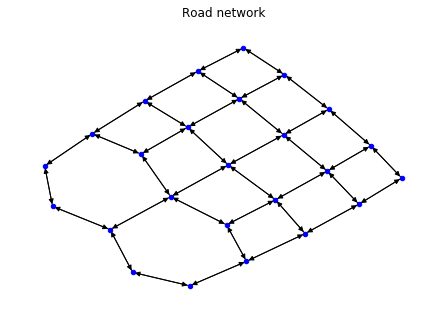

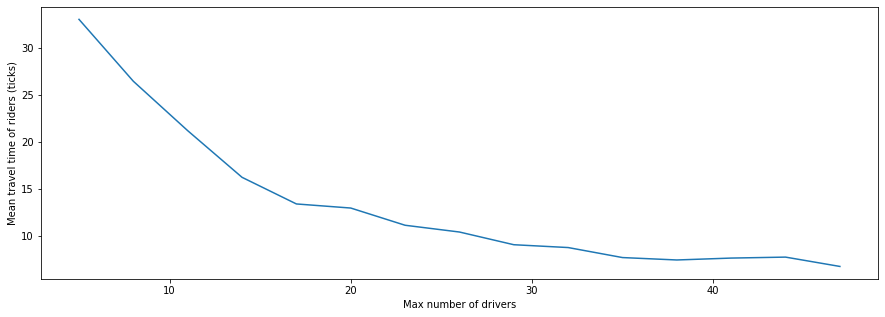

In [447]:
mean_travel_time_per_d = []
graph = generate_2D_graph(SIZE_MAP, coef_suppr=0.1, show=True)


for nb_d in MAX_NB_DRIVERS :
    sma = SMA()
    sma.setRoadGraph(graph)
    sma.addAgent(GeneratorAgent(0,nb_d,MAX_NB_RIDERS, seed=42))
    sma.run(NB_RUN)
    mean_travel_time_per_d.append(np.mean(sma.data["mean_travel_time_r"]))
    
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,mean_travel_time_per_d)
plt.xlabel('Max number of drivers')
plt.ylabel("Mean travel time of riders (ticks)")
#plt.legend()
plt.show()

Ou avec un réseau routier plus important :

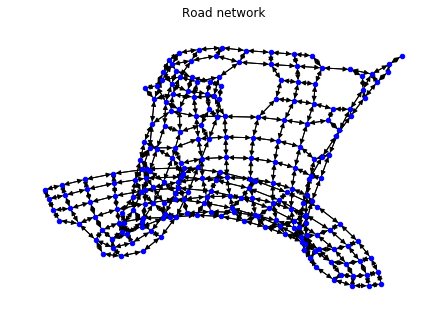

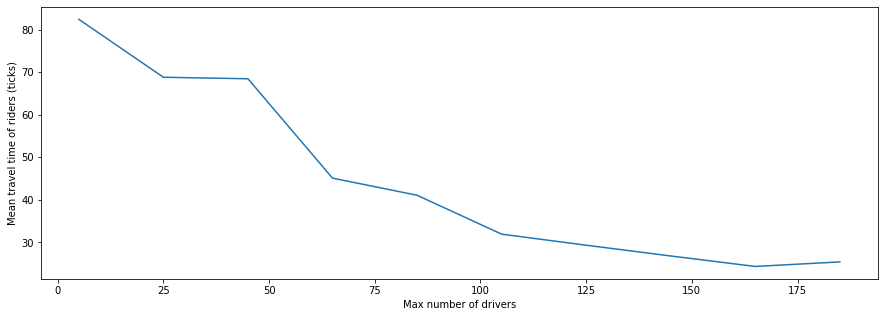

In [448]:
SIZE_MAP = 15 #graphe en grille donc NOMBRE DE NOEUDS = SIZE_MAP * SIZE_MAP
MAX_NB_DRIVERS = np.arange(5,200,20)
MAX_NB_RIDERS = 20
NB_RUN = 200

mean_travel_time_per_d = []
graph = generate_2D_graph(SIZE_MAP, coef_suppr=0.1, show=True)


for nb_d in MAX_NB_DRIVERS :
    sma = SMA()
    sma.setRoadGraph(graph)
    sma.addAgent(GeneratorAgent(0,nb_d,MAX_NB_RIDERS, seed=42))
    sma.run(NB_RUN)
    mean_travel_time_per_d.append(np.mean(sma.data["mean_travel_time_r"]))
    
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,mean_travel_time_per_d)
plt.xlabel('Max number of drivers')
plt.ylabel("Mean travel time of riders (ticks)")
#plt.legend()
plt.show()

# Bibliographie

Philippe Mathieu, Yann Secq.
Environment Updating and Agent Scheduling Policies in Agent-based Simulators. 
ICAART Conference, 2012, pp 170-175

Philippe Mathieu, Sébastien Picault, Yann Secq.
Design Patterns for Environments in Multi-agent Simulations. 
PRIMA Conference, 2015, pp 678-686

Philippe Mathieu, Gildas Morvan, Sébastien Picault.
Multi-level agent-based simulations: Four design patterns. 
Journal of Simulation Modelling Practice and Theory, Janv 2018
